# Generate a MR spectroscopic imaging (MRSI) NIfTI-MRS example manually
The aim of this notebook is to elucidate the different parts of a NIfTI-MRS format file.  
Some calculations and manipulations are made transparent and explicit here, but many others (e.g. orientation calculations) are still done by functions implemented in the spec2nii conversion program.

Data is taken from a single subject's 31P 3D-CSI scan on a Siemens Trio 3T (VB platform). The data is stored in the Siemens spectroscopy DICOM format.

In [1]:
from pathlib import Path
import numpy as np

import nibabel.nicom.dicomwrappers as nidcm
from spec2nii.dicomfunctions import process_siemens_csi
import matplotlib.pyplot as plt

import datetime
import json

import nibabel as nib
import h5py

<ipython-input-1-0f9e3dfd683c>:4: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  import nibabel.nicom.dicomwrappers as nidcm


### Load the data
This is a single coil 16x16x16 3T 31P dataset of a human brain.  

We are loading the data using using nibabel's DICOM reader, and interpreting the orientation information using the Siemens DICOM specific code in spec2nii.

In [2]:
dicom_file = Path('../data/Series0006=Inst001=uteCsi_Hamming_12x12x12_Long=1.3.12.2.1107.5.2.32.35031.2019102918364170636652991.IMA')

img = nidcm.wrapper_from_file(str(dicom_file))
           
specDataCmplx, currNiftiOrientation, dwelltime, meta = process_siemens_csi(img,{})

mainStr = img.dcm_data.SeriesDescription

print(f'Data description is "{mainStr}"')
print(f'Data size is {specDataCmplx.shape} (x,y,z,t)')
print(f'Data orientation affine is\n {currNiftiOrientation.Q44}')

Data description is "uteCsi Hamming 12x12x12 Long"
Data size is (16, 16, 16, 1024) (x,y,z,t)
Data orientation affine is
 [[ -14.375        -0.           -0.          116.82652378]
 [  -0.          -14.375        -0.          131.27689934]
 [   0.            0.           12.5        -101.46740484]
 [   0.            0.            0.            1.        ]]


### Voxel orientation calculations 
Have already been completed above using spec2nii code

### Metadata
In this section we manually assemble the meta-data that is required by, or may otherwise be stored in, NIfTI-MRS
#### Dimension information
First is the information about the higher data dimensions (the 5th - 7th dimensions)  

None required as there is no use of the optional higher NIfTI dimensions.

In [3]:
dim_dict = {}

#### Metadata required for minimum conformance
Three pieces of data **must** be specified for conformanace with the standard.

<ins>In the header extension</ins>  
**SpectrometerFrequency** , Array of doubles, See DICOM tag (0018,9098). Units: MHz.  
**ResonantNucleus**, Array of strings, See DICOM tag (0018,9100). Must be one of the DICOM recognized nuclei “1H”, “3HE”, “7LI”, “13C”, “19F”, “23NA”, “31P”, “129XE” or one named in the specified format. I.e. Mass number followed by the chemical symbol in uppercase.  

<ins>In the NIfTI header block</ins>   
**Dwelltime**. Units: s.  **Stored in pixdim[4]**

In [4]:
spectrometer_frequency_hz = meta.SpectrometerFrequency[0]
nucleus_str = meta.ResonantNucleus[0]

print(f'SpectrometerFrequency = {spectrometer_frequency_hz:0.6f} Hz')
print(f'ResonantNucleus = {nucleus_str}')
print(f'Dwelltime = {dwelltime:0.2e} s')

SpectrometerFrequency = 49.860130 Hz
ResonantNucleus = 31P
Dwelltime = 2.50e-04 s


#### Extract some optional standard-defined metadata as well 
The NIfTI-MRS standard includes definitions of some common MRS metadata.  
Though the use of it is optional, here we populate some of those fields for illustration. 
  
Timing parameters:  
**EchoTime**: double, Time from centroid of excitation to start of FID or centre of echo. Units: Seconds  
**RepetitionTime**: double, Sequence repetition time. Units: Seconds  

Device information:  
**DeviceSerialNumber**: string, Manufacturer's serial number of the device.  
**Manufacturer**: string, Manufacturer of the device.  
**ManufacturersModelName**: string, Manufacturer's model name of the device.  
**SoftwareVersions**: string, Manufacturer's designation of the software version.  

Subject information:  
**PatientDoB**: string YYYYMMDD, Date of birth of the named Patient.  
**PatientName**: string, Patient's full name.  
**PatientPosition**: string, Patient position descriptor relative to the equipment.  
**PatientSex**: string, Sex of the named Patient. ‘M’, ‘F’, ‘O’.  
**PatientWeight**: Number, Weight of the Patient in kilograms.  

Some standard-defined conversion metadata:  
**ConversionMethod**: String, Program used for conversion. May include additional information like software version.  
**ConversionTime**: String  “YYYY-MM-DDThh:mm:ss.sss”, Time and date of conversion. ISO 8601 compliant format  
**OriginalFile**: String, Name and extension of the original file  

In [18]:
echo_time_s = meta.standard_data['EchoTime']
repetition_time_s = meta.standard_data['RepetitionTime']

print(f'EchoTime = {echo_time_s:0.3f} s')
print(f'RepetitionTime = {repetition_time_s:0.3f} s\n')


DeviceSerialNumber = meta.standard_data['DeviceSerialNumber']
Manufacturer = meta.standard_data['Manufacturer']
ManufacturersModelName = meta.standard_data['ManufacturersModelName']
SoftwareVersions = meta.standard_data['SoftwareVersions']

print(f'DeviceSerialNumber = {DeviceSerialNumber}')
print(f'Manufacturer = {Manufacturer}')
print(f'ManufacturersModelName = {ManufacturersModelName}')
print(f'SoftwareVersions = {SoftwareVersions}\n')

PatientDoB = meta.standard_data['PatientDoB']
PatientName = meta.standard_data['PatientName']
PatientPosition = meta.standard_data['PatientPosition']
PatientSex = meta.standard_data['PatientSex']
PatientWeight = meta.standard_data['PatientWeight']

print(f'PatientDoB = {PatientDoB}')
print(f'PatientName = {PatientName}')
print(f'PatientPosition = {PatientPosition}')
print(f'PatientSex = {PatientSex}')
print(f'PatientWeight = {PatientWeight}\n')


conversion_method = 'Manual'
conversion_time = datetime.datetime.now().isoformat(sep='T',timespec='milliseconds')
original_file = [dicom_file.name]
print(f'ConversionMethod = {conversion_method}')
print(f'ConversionTime = {conversion_time}')
print(f'OriginalFile = {original_file}')


EchoTime = 0.002 s
RepetitionTime = 1.000 s

DeviceSerialNumber = 35031
Manufacturer = SIEMENS
ManufacturersModelName = TrioTim
SoftwareVersions = syngo MR B17

PatientDoB = 19860808
PatientName = O3T_CD01_14622
PatientPosition = HFS
PatientSex = M
PatientWeight = 80.0

ConversionMethod = Manual
ConversionTime = 2021-07-01T10:03:42.072
OriginalFile = ['Series0006=Inst001=uteCsi_Hamming_12x12x12_Long=1.3.12.2.1107.5.2.32.35031.2019102918364170636652991.IMA']


## Make the JSON string representation of the metadata
Use Python's inbuilt json library to convert a combined dict of metadata into the header extension string.  

In [19]:
meta_dict = {**dim_dict,
            'SpectrometerFrequency':[spectrometer_frequency_hz,],
            'ResonantNucleus':[nucleus_str,],
            'EchoTime':echo_time_s,
            'RepetitionTime':repetition_time_s,             
            'DeviceSerialNumber':DeviceSerialNumber,
            'Manufacturer':Manufacturer,
            'ManufacturersModelName':ManufacturersModelName,
            'SoftwareVersions':SoftwareVersions,
            'PatientDoB':PatientDoB,
            'PatientName':PatientName,
            'PatientPosition':PatientPosition,
            'PatientSex':PatientSex,
            'PatientWeight':PatientWeight,
            'ConversionMethod':conversion_method,
            'ConversionTime':conversion_time,
            'OriginalFile':original_file}

json_full = json.dumps(meta_dict)
print(json_full)

{"SpectrometerFrequency": [49.86013], "ResonantNucleus": ["31P"], "EchoTime": 0.0023, "RepetitionTime": 1.0, "DeviceSerialNumber": "35031", "Manufacturer": "SIEMENS", "ManufacturersModelName": "TrioTim", "SoftwareVersions": "syngo MR B17", "PatientDoB": "19860808", "PatientName": "O3T_CD01_14622", "PatientPosition": "HFS", "PatientSex": "M", "PatientWeight": 80.0, "ConversionMethod": "Manual", "ConversionTime": "2021-07-01T10:03:42.072", "OriginalFile": ["Series0006=Inst001=uteCsi_Hamming_12x12x12_Long=1.3.12.2.1107.5.2.32.35031.2019102918364170636652991.IMA"]}


## Data conventions
NIfTI-MRS defines a strict phase and frequency convention. This is to ensure that spectra are displayed consistently.  
Here we ensure that this data conforms to this convention by plotting it.
The convention states:
- The frequency scale should increase from left to right. For nuclei with a gyromagnetic ratio > 0 this corresponds to resonances from nuclei with less shielding (more deshielding) and therefore experiencing a higher magnetic field, appearing on the left. I.e. they have more negative (higher magnitude) Larmor frequencies noting $\omega=-\gamma B_0$.
- In a right-handed coordinate system (x corresponding to real values, y imaginary values, and z time) in the time-domain:  
    - data arising from nuclei with a positive gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a positive (counter-clockwise) rotation.
    - data arising from nuclei with a negative gyromagnetic ratio should be stored so that positive relative frequencies (on the absolute scale, relative to the spectrometer reference frequency) appear to have a negative (clockwise) rotation.  

Note that in literature the frequency is often also plotted with a different frequency scale showing more positive relative frequencies on the left. This preserves the orientation of the spectrum but corresponds to a scale equal to  $|\omega|-|\omega_{\textrm{ref}}|$.

Here the data doesn't match the convention so we conjugate the data

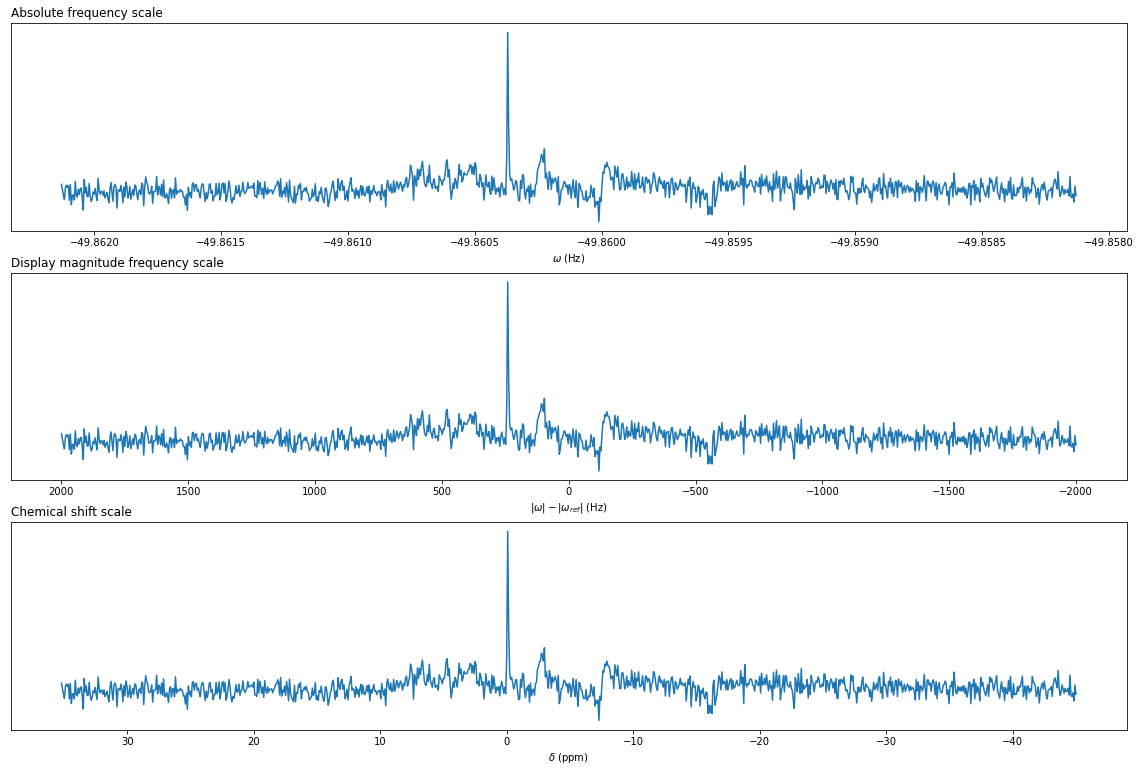

In [7]:
test_FID = specDataCmplx[7,7,10,:]

# Make absolute frequency scale (remember the -ve sign in omega=-gamma.B0)
spectral_width_hz = 1/dwelltime
transmitter_frequency_mhz = spectrometer_frequency_hz

npoints = test_FID.shape[0]
frequency_axis = np.linspace(-spectral_width_hz/2,spectral_width_hz/2,npoints) 
abs_freq_axis = -transmitter_frequency_mhz + frequency_axis/1E6
# Display frequency axis
frequency_axis *= -1
# Chemical shift axis (shifted to TMS)
c_shift_axis = -4.9+frequency_axis/transmitter_frequency_mhz


spec_fft = np.fft.fftshift(np.fft.fft(test_FID*np.exp(-1j*np.pi/2)))

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,13))
ax1.plot(abs_freq_axis,np.real(spec_fft))
ax1.set_yticks([])
ax1.set_xlabel('$\omega$ (Hz)')
ax1.set_title('Absolute frequency scale',loc='left')

ax2.plot(frequency_axis,np.real(spec_fft))
ax2.set_yticks([])
ax2.invert_xaxis()
ax2.set_xlabel('$|\omega|-|\omega_{ref}|$ (Hz)')
ax2.set_title('Display magnitude frequency scale',loc='left')

ax3.plot(c_shift_axis,np.real(spec_fft))
ax3.set_yticks([])
ax3.invert_xaxis()
ax3.set_xlabel('$\delta$ (ppm)')
ax3.set_title('Chemical shift scale',loc='left')

plt.show()

## Write the NIfTI-MRS file 
Using the NIfTI-2 format as recommended (but not required) by the specification.

In [20]:
save_path = Path('../examples')
newobj = nib.nifti2.Nifti2Image(specDataCmplx, currNiftiOrientation.Q44)

# Write new header
pixDim = newobj.header['pixdim']
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form >0
newobj.header.set_qform(currNiftiOrientation.Q44)

# Set version information 
newobj.header['intent_name'] = b'mrs_v0_3'

# Write extension with ecode 44
extension = nib.nifti1.Nifti1Extension(44, json_full.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,save_path / 'example_04.nii.gz')

## Write hdf5 to check against

In [21]:
with h5py.File(save_path / 'example_04.h5', 'w') as h5f:
    h5f.create_dataset('example_04_data', data=specDataCmplx)
    h5f.create_dataset('example_04_header_ext', data=json_full)

## Load and check

In [22]:
check_nifti = nib.load(save_path / 'example_04.nii.gz')

with h5py.File(save_path / 'example_04.h5','r') as h5f:
    check_hdf5 = h5f['example_04_data'][:]
    
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64),specDataCmplx)
assert np.allclose(check_nifti.get_fdata(dtype=np.complex64),check_hdf5)

loaded_he_content = json.loads(check_nifti.header.extensions[0].get_content())

assert loaded_he_content == meta_dict
